In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


In [30]:
class ModelComparisonWithBinning:
    def __init__(self, dataframe, target_column):
        """
        Initialize the ModelComparisonWithBinning class with a dataset and the target column.

        :param dataframe: pd.DataFrame containing the dataset
        :param target_column: str, name of the target column for classification
        """
        self.dataframe = dataframe
        self.target_column = target_column
        self.X = dataframe.drop(columns=[target_column])
        self.y = dataframe[target_column]
        
        # Apply MinMaxScaler to normalize the dataset
        self.scaler = MinMaxScaler()
        self.X_scaled = pd.DataFrame(self.scaler.fit_transform(self.X), columns=self.X.columns)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X_scaled, self.y, test_size=0.3, random_state=42)
        self.xgb_model = None
        self.rf_model = None

    def apply_static_binning(self, bins):
        """
        Apply static binning (equal-width binning) to all numeric columns.

        :param bins: int, number of bins for static binning
        :return: pd.DataFrame with binned data
        """
        binner = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform', subsample=None)
        binned_data = binner.fit_transform(self.X_scaled)
        return pd.DataFrame(binned_data, columns=self.X.columns)

    def apply_quantile_binning(self, bins):
        """
        Apply quantile binning (equal-frequency binning) to all numeric columns.

        :param bins: int, number of bins for quantile binning
        :return: pd.DataFrame with binned data
        """
        binner = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='quantile', subsample=None)
        binned_data = binner.fit_transform(self.X_scaled)
        return pd.DataFrame(binned_data, columns=self.X.columns)

    def train_xgb(self, X_train):
        """
        Train an XGBoost model (XGBClassifier).

        :param X_train: Training data for XGBClassifier
        """
        self.xgb_model = XGBClassifier(eval_metric='logloss')
        self.xgb_model.fit(X_train, self.y_train)

    def train_random_forest(self, X_train, n_estimators=100):
        """
        Train a Random Forest model.

        :param X_train: Training data for Random Forest
        :param n_estimators: int, number of trees in the forest
        """
        self.rf_model = RandomForestClassifier(n_estimators=n_estimators)
        self.rf_model.fit(X_train, self.y_train)

    def evaluate_model(self, model, X_test, model_name):
        """
        Evaluate the model using accuracy, precision, recall, and F1 score.

        :param model: trained model to evaluate
        :param X_test: Test data for evaluation
        :param model_name: str, name of the model for display purposes
        :return: dict with evaluation metrics
        """
        y_pred = model.predict(X_test)
        metrics = {
            'Model': model_name,
            'Accuracy': accuracy_score(self.y_test, y_pred),
            'Precision': precision_score(self.y_test, y_pred, average='weighted'),
            'Recall': recall_score(self.y_test, y_pred, average='weighted'),
            'F1 Score': f1_score(self.y_test, y_pred, average='weighted')
        }
        return metrics

    def plot_feature_importance(self, feature_names, importances, title):
        """
        Plot feature importance for the models.

        :param feature_names: List of feature names
        :param importances: List of feature importance values
        :param title: str, title for the plot
        """
        plt.figure(figsize=(10, 6))
        feature_importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        feature_importance_df.plot(kind='bar', color='skyblue')
        plt.title(title)
        plt.ylabel("Feature Importance")
        plt.tight_layout()
        plt.show()

    def compare_metrics(self, X_train, X_test):
        """
        Train both models (XGB and Random Forest) and compare their evaluation metrics.

        :param X_train: Training data
        :param X_test: Test data
        """
        # Train and evaluate XGBoost
        self.train_xgb(X_train)
        xgb_metrics = self.evaluate_model(self.xgb_model, X_test, "XGBoost")
        print("\nXGBoost Metrics:")
        print(xgb_metrics)

        # Train and evaluate Random Forest
        self.train_random_forest(X_train)
        rf_metrics = self.evaluate_model(self.rf_model, X_test, "Random Forest")
        print("\nRandom Forest Metrics:")
        print(rf_metrics)

    def compare_feature_importance(self, X_train, feature_names):
        """
        Train both models (XGB and Random Forest) and compare their feature importance.

        :param X_train: Training data
        :param feature_names: List of feature names
        """
        # Train and plot XGBoost feature importance
        self.train_xgb(X_train)
        self.plot_feature_importance(feature_names, self.xgb_model.feature_importances_, "Feature Importance - XGBoost")

        # Train and plot Random Forest feature importance
        self.train_random_forest(X_train)
        self.plot_feature_importance(feature_names, self.rf_model.feature_importances_, "Feature Importance - Random Forest")

    def compare_with_binning(self, bins):
        """
        Compare the models on unbinned data and after applying static and quantile binning.
        Metrics are compared first, followed by feature importance comparison.

        :param bins: int, number of bins to use for discretization
        """
        print("\n--- Original Data (Scaled) ---")
        # Compare metrics on original (unbinned) data
        self.compare_metrics(self.X_train, self.X_test)

        # Compare feature importance on original (unbinned) data
        self.compare_feature_importance(self.X_train, self.X.columns)

        print("\n--- Static Binned Data ---")
        # Apply static binning
        X_train_static_binned = self.apply_static_binning(bins=bins)
        X_train_static, X_test_static = train_test_split(X_train_static_binned, test_size=0.3, random_state=42)

        # Compare metrics on static binned data
        self.compare_metrics(X_train_static, X_test_static)

        # Compare feature importance on static binned data
        self.compare_feature_importance(X_train_static, self.X.columns)

        print("\n--- Quantile Binned Data ---")
        # Apply quantile binning
        X_train_quantile_binned = self.apply_quantile_binning(bins=bins)
        X_train_quantile, X_test_quantile = train_test_split(X_train_quantile_binned, test_size=0.3, random_state=42)

        # Compare metrics on quantile binned data
        self.compare_metrics(X_train_quantile, X_test_quantile)

        # Compare feature importance on quantile binned data
        self.compare_feature_importance(X_train_quantile, self.X.columns)



--- Original Data (Scaled) ---

XGBoost Metrics:
{'Model': 'XGBoost', 'Accuracy': 0.9707602339181286, 'Precision': 0.9709250491883916, 'Recall': 0.9707602339181286, 'F1 Score': 0.970807351651423}

Random Forest Metrics:
{'Model': 'Random Forest', 'Accuracy': 0.9649122807017544, 'Precision': 0.9649541140481607, 'Recall': 0.9649122807017544, 'F1 Score': 0.9647902680643604}


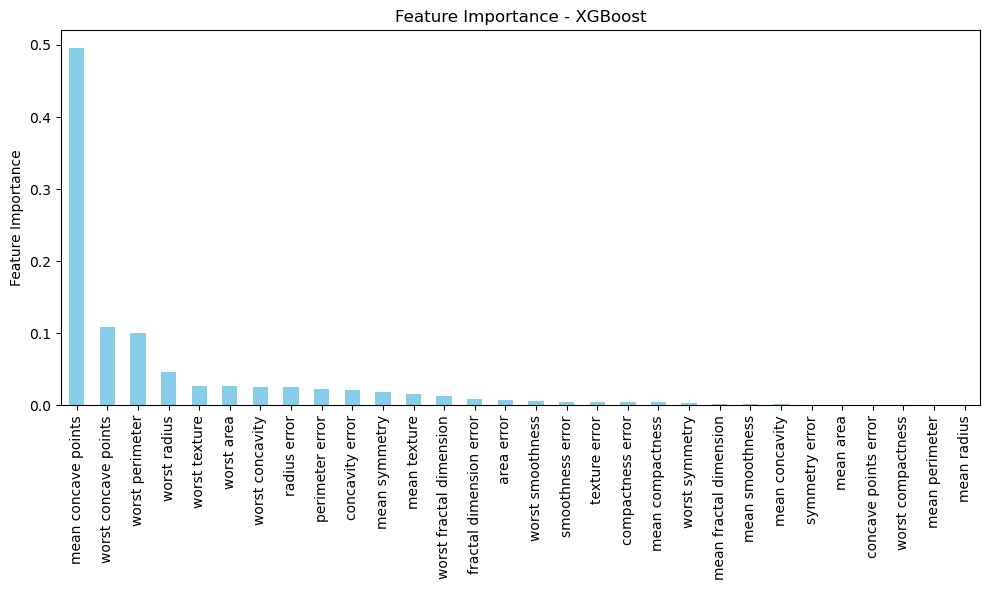

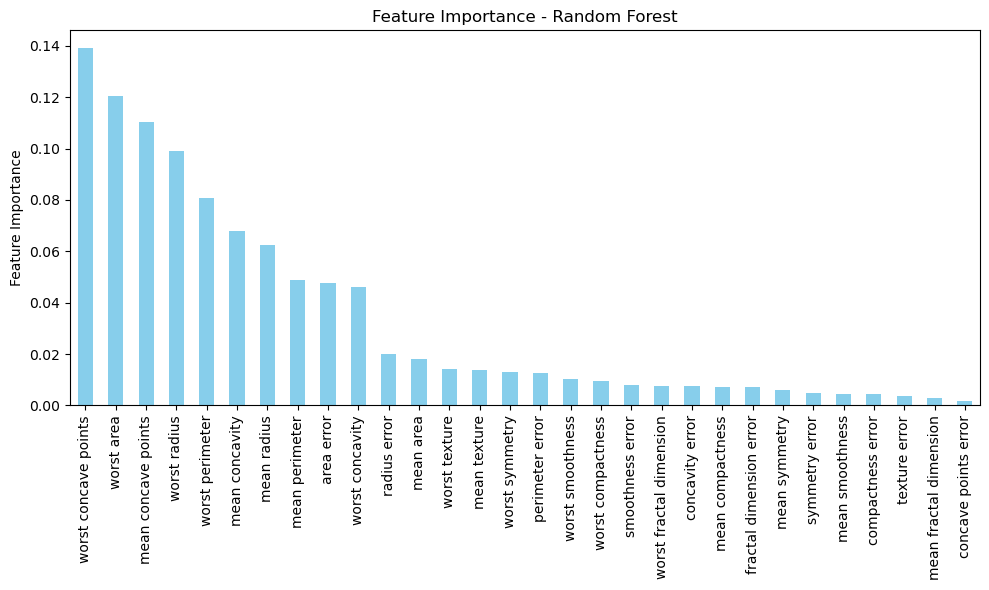


--- Static Binned Data ---

XGBoost Metrics:
{'Model': 'XGBoost', 'Accuracy': 0.9473684210526315, 'Precision': 0.9476066773241515, 'Recall': 0.9473684210526315, 'F1 Score': 0.9474532329725615}

Random Forest Metrics:
{'Model': 'Random Forest', 'Accuracy': 0.9707602339181286, 'Precision': 0.9711000474158369, 'Recall': 0.9707602339181286, 'F1 Score': 0.970603923775359}


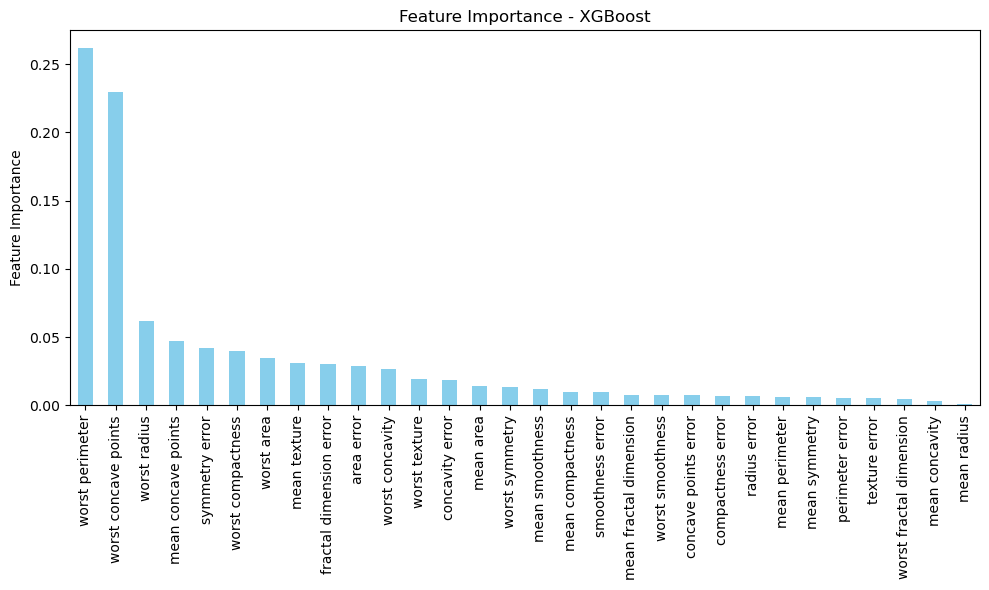

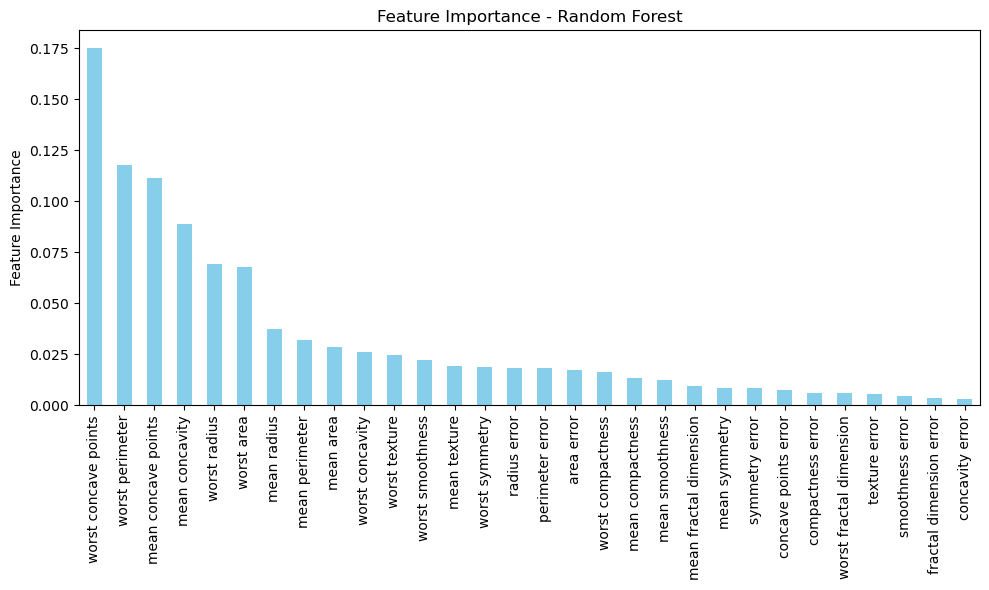


--- Quantile Binned Data ---

XGBoost Metrics:
{'Model': 'XGBoost', 'Accuracy': 0.9766081871345029, 'Precision': 0.9770376594606983, 'Recall': 0.9766081871345029, 'F1 Score': 0.9766816281357601}

Random Forest Metrics:
{'Model': 'Random Forest', 'Accuracy': 0.9766081871345029, 'Precision': 0.9767354302298219, 'Recall': 0.9766081871345029, 'F1 Score': 0.9765268453762402}


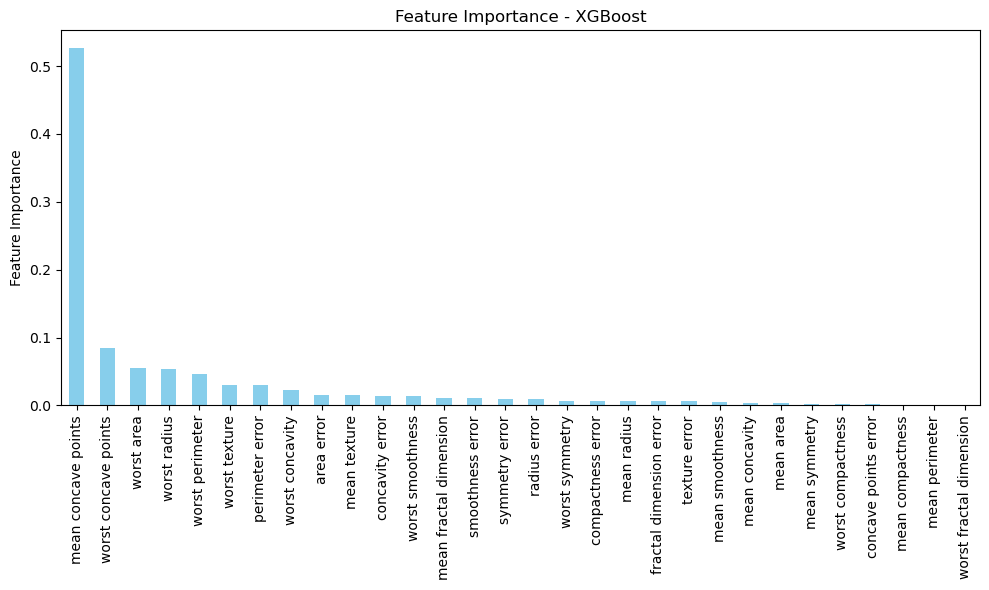

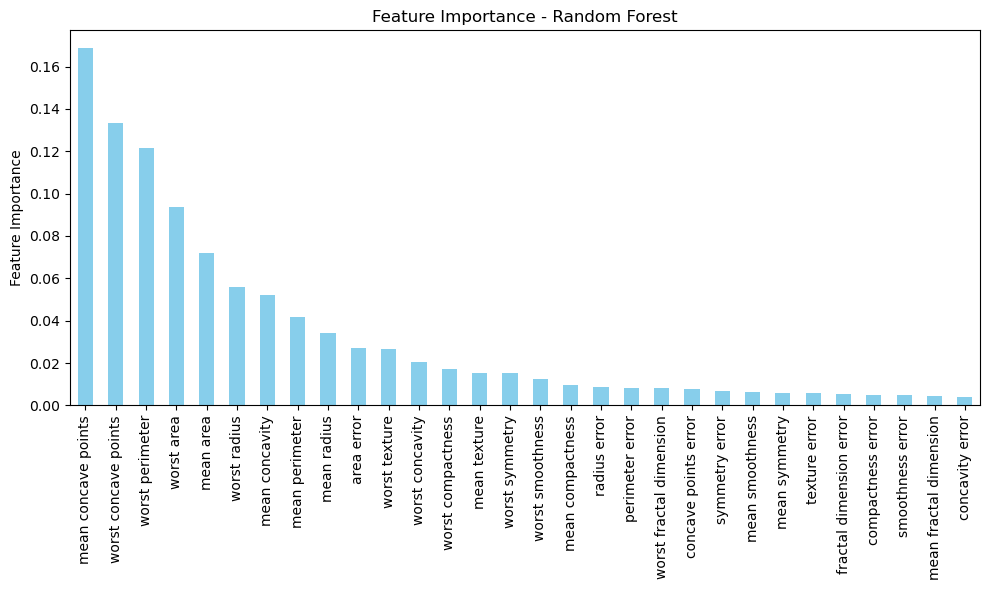

In [31]:
# Load a sample dataset
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target

# Create the ModelComparisonWithBinning object
model_comparison = ModelComparisonWithBinning(df, target_column='target')

# Compare models using 3 bins for discretization
model_comparison.compare_with_binning(bins=10)


In [39]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
spambase = fetch_ucirepo(id=94) 
  
# data (as pandas dataframes) 
X = spambase.data.features 
y = spambase.data.targets 
  
# metadata 
print(spambase.metadata) 
  
# variable information 
print(spambase.variables) 

{'uci_id': 94, 'name': 'Spambase', 'repository_url': 'https://archive.ics.uci.edu/dataset/94/spambase', 'data_url': 'https://archive.ics.uci.edu/static/public/94/data.csv', 'abstract': 'Classifying Email as Spam or Non-Spam', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 4601, 'num_features': 57, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1999, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C53G6X', 'creators': ['Mark Hopkins', 'Erik Reeber', 'George Forman', 'Jaap Suermondt'], 'intro_paper': None, 'additional_info': {'summary': 'The "spam" concept is diverse: advertisements for products/web sites, make money fast schemes, chain letters, pornography...\n\nThe classification task for this dataset is to determine whether a given email is spam or not.\n\t\nOur collecti


--- Original Data (Scaled) ---

XGBoost Metrics:
{'Model': 'XGBoost', 'Accuracy': 0.9587255611875453, 'Precision': 0.9587616389182434, 'Recall': 0.9587255611875453, 'F1 Score': 0.9586559358823541}

Random Forest Metrics:
{'Model': 'Random Forest', 'Accuracy': 0.9551049963794352, 'Precision': 0.9551810312311768, 'Recall': 0.9551049963794352, 'F1 Score': 0.9550105476803971}


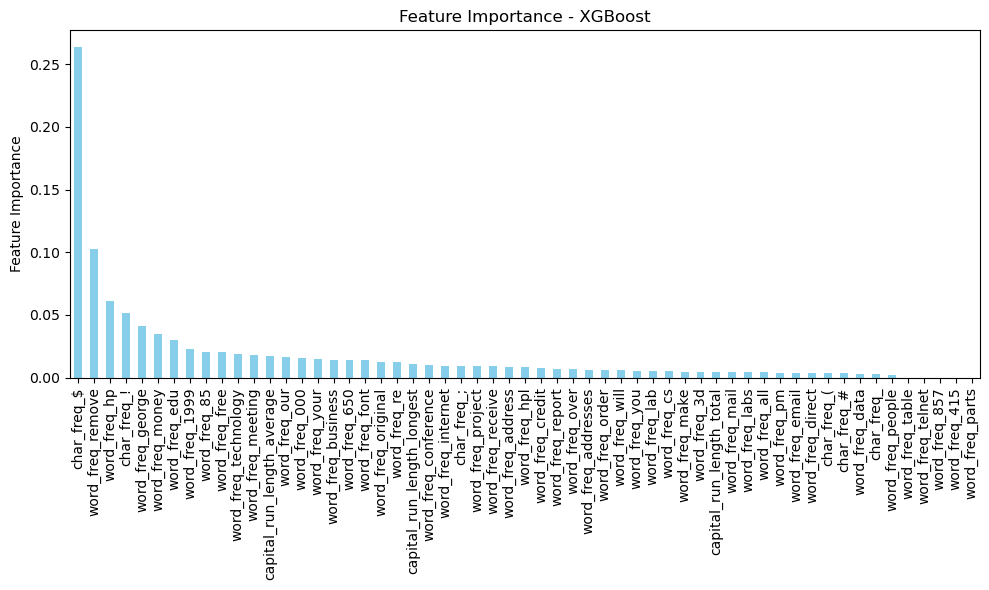

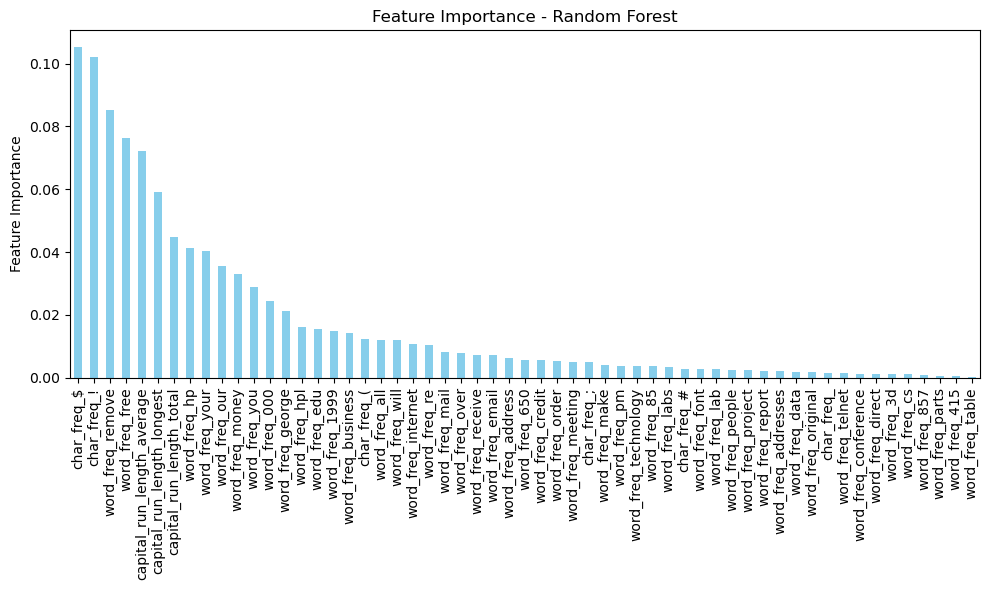


--- Static Binned Data ---

XGBoost Metrics:
{'Model': 'XGBoost', 'Accuracy': 0.8790731354091238, 'Precision': 0.8794052137018202, 'Recall': 0.8790731354091238, 'F1 Score': 0.8782657148367556}

Random Forest Metrics:
{'Model': 'Random Forest', 'Accuracy': 0.8696596669080376, 'Precision': 0.8693900752421594, 'Recall': 0.8696596669080376, 'F1 Score': 0.8694576085334578}


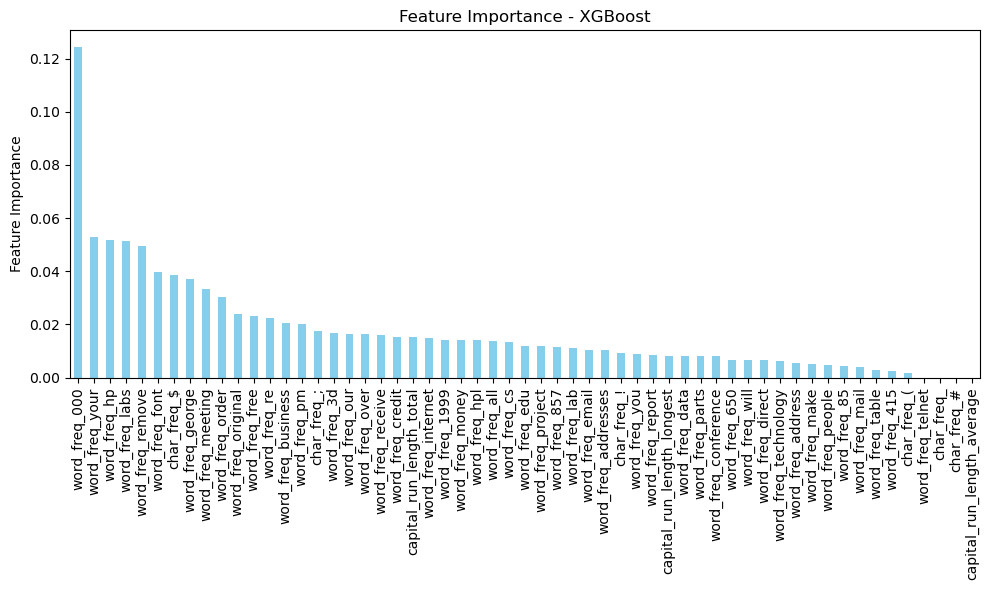

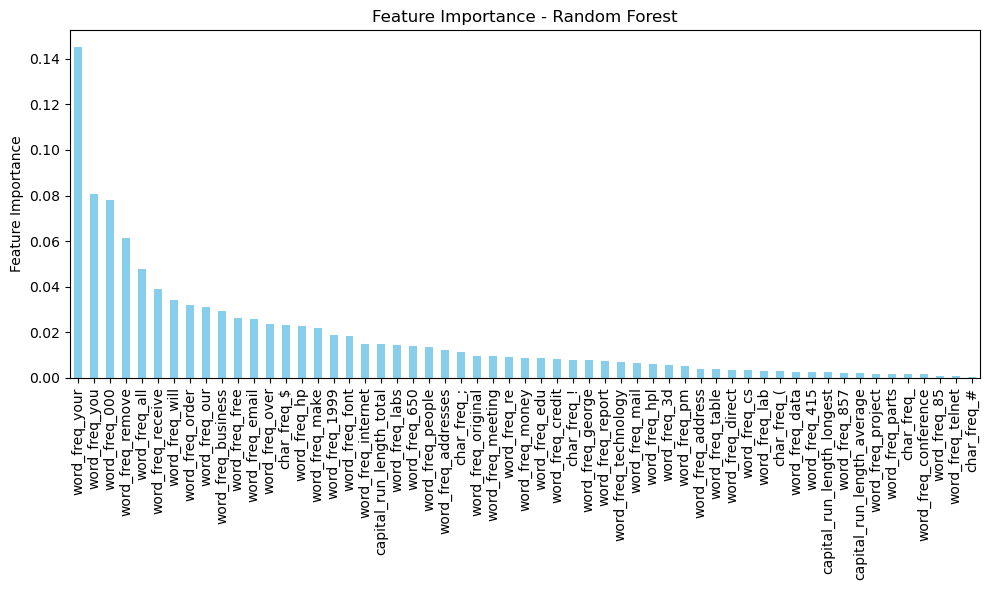


--- Quantile Binned Data ---


d:\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small


XGBoost Metrics:
{'Model': 'XGBoost', 'Accuracy': 0.945691527878349, 'Precision': 0.9456454310166997, 'Recall': 0.945691527878349, 'F1 Score': 0.9456435052929343}

Random Forest Metrics:
{'Model': 'Random Forest', 'Accuracy': 0.9478638667632151, 'Precision': 0.9480527335189272, 'Recall': 0.9478638667632151, 'F1 Score': 0.947709082496338}


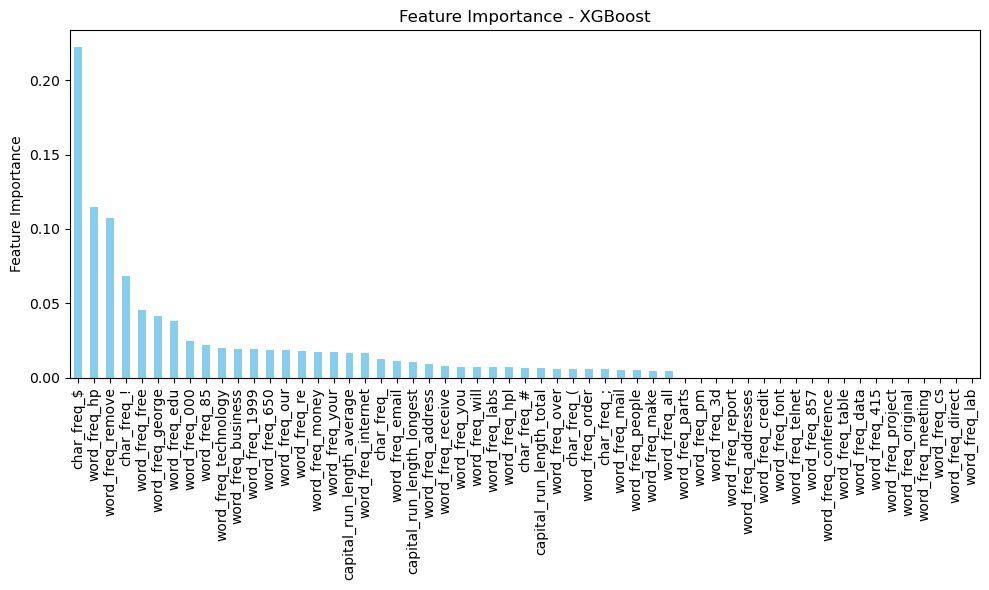

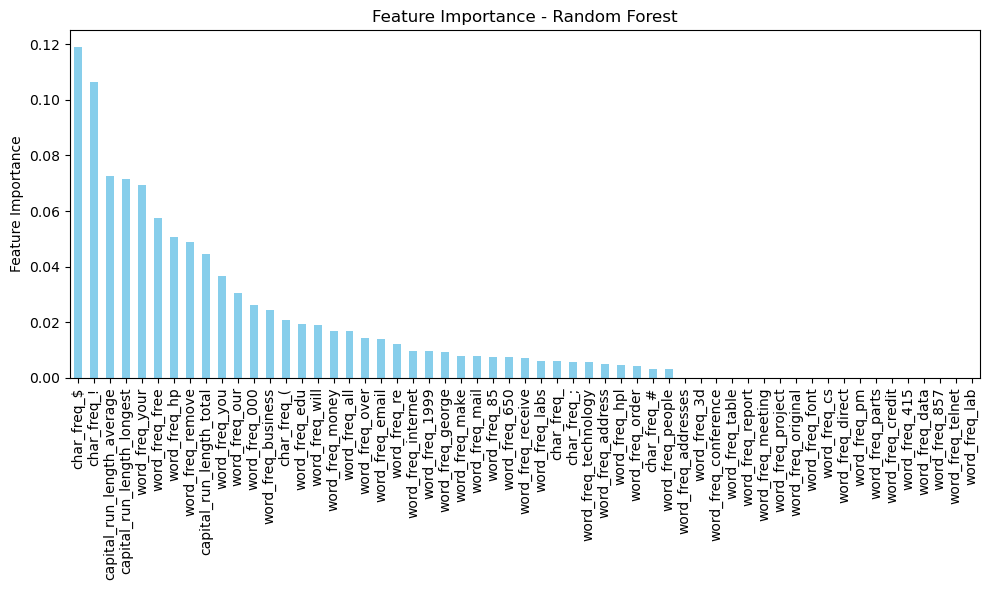

In [44]:
df = pd.DataFrame(data=spambase.data.features)
df['target'] = spambase.data.targets 

df.columns = df.columns.astype(str)  # Ensure all column names are strings
df.columns = df.columns.str.replace(r'[<>\[\]]', '', regex=True)  # Remove [, ], <, >

# Create the ModelComparisonWithBinning object
model_comparison = ModelComparisonWithBinning(df, target_column='target')

# Compare models using 3 bins for discretization
model_comparison.compare_with_binning(bins=10)

1. Repozytorium.
2. Rozkłady danych dla datasetów - ważne
3. KNN
4. Lasso
5. W przyszłym tygodniu dać znać, że się pchnęło.